In [99]:
from tqdm import tqdm
from sys import getsizeof
from timeit import default_timer as timer

import numpy as np
import sisl
import sisl.viz
from src.grogu_magn.useful import *
from mpi4py import MPI
import pickle
from numpy.linalg import inv
import warnings

"""    
# Some input parsing
parser = argparse.ArgumentParser()
parser.add_argument('--kset'    , dest = 'kset'   , default  = 2         , type=int  , help = 'k-space resolution of Jij calculation')
parser.add_argument('--kdirs'   , dest = 'kdirs'  , default  = 'xyz'                 , help = 'Definition of k-space dimensionality')
parser.add_argument('--eset'    , dest = 'eset'   , default  = 42        , type=int  , help = 'Number of energy points on the contour')
parser.add_argument('--eset-p'  , dest = 'esetp'  , default  = 10        , type=int  , help = 'Parameter tuning the distribution on the contour')
parser.add_argument('--input'   , dest = 'infile' , required = True                  , help = 'Input file name')
parser.add_argument('--output'  , dest = 'outfile', required = True                  , help = 'Output file name')
parser.add_argument('--Ebot'    , dest = 'Ebot'   , default  = -20.0     , type=float, help = 'Bottom energy of the contour')
parser.add_argument('--npairs'  , dest = 'npairs' , default  = 1         , type=int  , help = 'Number of unitcell pairs in each direction for Jij calculation')
parser.add_argument('--adirs'   , dest = 'adirs'  , default  = False                 , help = 'Definition of pair directions')
parser.add_argument('--use-tqdm', dest = 'usetqdm', default  = 'not'                 , help = 'Use tqdm for progressbars or not')
parser.add_argument('--cutoff'  , dest = 'cutoff' , default  = 100.0     , type=float, help = 'Real space cutoff for pair generation in Angs')
parser.add_argument('--pairfile', dest = 'pairfile', default  = False    ,             help = 'File to read pair information')
args = parser.parse_args()
"""
# runtime information
times = dict()
times["start_time"] = timer()
########################
# it works if data is in downloads folder
########################
sisl.__version__

'0.14.3'

In [100]:
dat = sisl.io.siesta.eigSileSiesta(
    "/Users/danielpozsar/Downloads/nojij/Fe3GeTe2/monolayer/soc/lat3_791/Fe3GeTe2.EIG"
)
siesta_eigs = dat.read_data()
siesta_eigs.min()

-12.806878959999999

In [101]:
Ef = dat.read_fermi_level()
Ef

-5.82448514

In [102]:
################################################################################
#################################### INPUT #####################################
################################################################################
path = (
    "/Users/danielpozsar/Downloads/nojij/Fe3GeTe2/monolayer/soc/lat3_791/Fe3GeTe2.fdf"
)
outfile = "./Fe3GeTe2"

# this information needs to be given at the input!!
scf_xcf_orientation = np.array([0, 0, 1])  # z
# list of reference directions for around which we calculate the derivatives
# o is the quantization axis, v and w are two axes perpendicular to it
# at this moment the user has to supply o,v,w on the input.
# we can have some default for this
ref_xcf_orientations = [
    dict(o=np.array([1, 0, 0]), vw=[np.array([0, 1, 0]), np.array([0, 0, 1])]),
    dict(o=np.array([0, 1, 0]), vw=[np.array([1, 0, 0]), np.array([0, 0, 1])]),
    dict(o=np.array([0, 0, 1]), vw=[np.array([1, 0, 0]), np.array([0, 1, 0])]),
]
magnetic_entities = [
    dict(atom=3, l=2),
    dict(atom=4),
    dict(atom=5, l=2),
]
pairs = [
    dict(ai=0, aj=1, Ruc=np.array([0, 0, 0])),
    dict(ai=0, aj=2, Ruc=np.array([0, 0, 0])),
    dict(ai=1, aj=2, Ruc=np.array([0, 0, 0])),
    dict(ai=0, aj=2, Ruc=np.array([-1, -1, 0])),
    dict(ai=1, aj=2, Ruc=np.array([-1, -1, 0])),
    dict(ai=0, aj=2, Ruc=np.array([-1, 0, 0])),
    dict(ai=1, aj=2, Ruc=np.array([-1, 0, 0])),
]
# Brilloun zone sampling and Green function contour integral
kset = 10
kdirs = "xy"
ebot = -13
eset = 600
esetp = 10000
################################################################################
#################################### INPUT #####################################
################################################################################

# MPI parameters
comm = MPI.COMM_WORLD
size = comm.Get_size()
rank = comm.Get_rank()
root_node = 0

# rename outfile
if not outfile.endswith(".pickle"):
    outfile += ".pickle"

simulation_parameters = dict(
    path=path,
    outpath=outfile,
    scf_xcf_orientation=scf_xcf_orientation,
    ref_xcf_orientations=ref_xcf_orientations,
    kset=kset,
    kdirs=kdirs,
    ebot=ebot,
    eset=eset,
    esetp=esetp,
    parallel_size=size,
)

# digestion of the input
# read sile
fdf = sisl.get_sile(path)
# read in hamiltonian
dh = fdf.read_hamiltonian()
simulation_parameters["cell"] = fdf.read_geometry().cell

# unit cell index
uc_in_sc_idx = dh.lattice.sc_index([0, 0, 0])

if rank == root_node:
    print_parameters(simulation_parameters)
    times["setup_time"] = timer()
    print(f"Setup done. Elapsed time: {times['setup_time']} s")
    print(
        "================================================================================================================================================================"
    )

Input file: 
/Users/danielpozsar/Downloads/nojij/Fe3GeTe2/monolayer/soc/lat3_791/Fe3GeTe2.fdf
Output file: 
./Fe3GeTe2.pickle
Number of nodes in the parallel cluster:  1
Cell [Ang]: 
[[ 3.79100000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89550000e+00  3.28310231e+00  0.00000000e+00]
 [ 1.25954923e-15  2.18160327e-15  2.05700000e+01]]
DFT axis: 
[0 0 1]
Quantization axis and perpendicular rotation directions:
[1 0 0]  --»  [array([0, 1, 0]), array([0, 0, 1])]
[0 1 0]  --»  [array([1, 0, 0]), array([0, 0, 1])]
[0 0 1]  --»  [array([1, 0, 0]), array([0, 1, 0])]
Parameters for the contour integral:
Number of k points:  10
k point directions:  xy
Ebot:  -13
Eset:  600
Esetp:  10000
Setup done. Elapsed time: 3484.176097333 s


xyz[-3:]: red, green, blue
2.745163300331324
2.5835033632437767
2.583501767937866
2.583541444641373


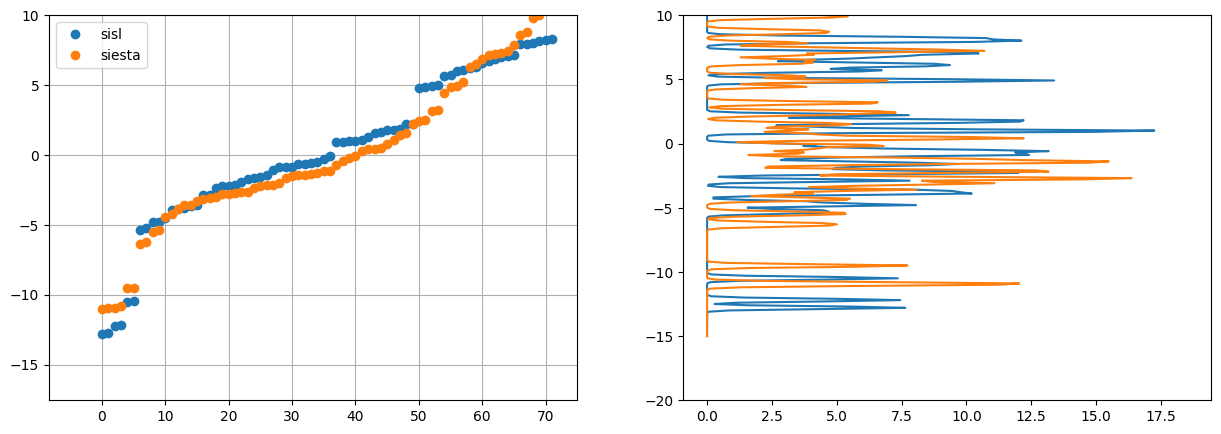

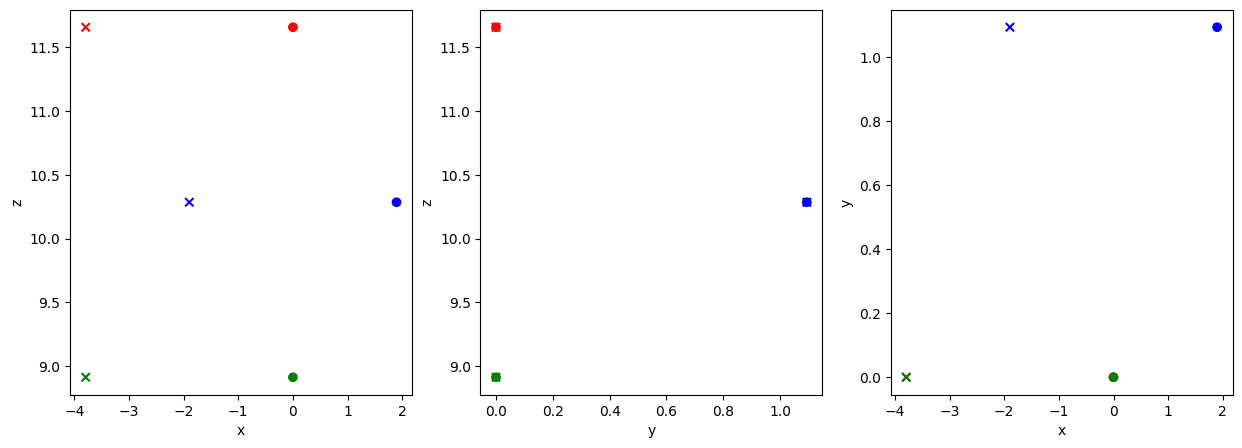

In [103]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(np.sort(dh.eigh()), marker="o", linestyle=" ", label="sisl")
plt.plot(np.sort(siesta_eigs[0, 0]), marker="o", linestyle=" ", label="siesta")
plt.ylim(None, 10)
plt.xlim(None, 75)
plt.legend()
plt.grid()
plt.subplot(122)
DOS = sisl.physics.electron.DOS(np.linspace(-15, 85, 1000), dh.eigh())
plt.plot(DOS, np.linspace(-15, 85, 1000))
DOS = sisl.physics.electron.DOS(np.linspace(-15, 85, 1000), siesta_eigs[0, 0])
plt.plot(DOS, np.linspace(-15, 85, 1000))
plt.ylim(None, 10)

coords = dh.xyz[-3:]

shift = np.array([-1, 0, 0]) @ simulation_parameters["cell"]


plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.scatter(coords[:, 0], coords[:, 2], color=["r", "g", "b"])
plt.scatter(
    (coords + shift)[:, 0], (coords + shift)[:, 2], color=["r", "g", "b"], marker="x"
)
plt.xlabel("x")
plt.ylabel("z")
plt.subplot(132)
plt.scatter(coords[:, 1], coords[:, 2], color=["r", "g", "b"])
plt.scatter(
    (coords + shift)[:, 1], (coords + shift)[:, 2], color=["r", "g", "b"], marker="x"
)
plt.xlabel("y")
plt.ylabel("z")
plt.subplot(133)
plt.scatter(coords[:, 0], coords[:, 1], color=["r", "g", "b"])
plt.scatter(
    (coords + shift)[:, 0], (coords + shift)[:, 1], color=["r", "g", "b"], marker="x"
)
plt.xlabel("x")
plt.ylabel("y")
print("xyz[-3:]: red, green, blue")

print(np.linalg.norm(coords[0] - coords[1]))
print(np.linalg.norm(coords[0] - coords[2]))
print(np.linalg.norm(coords[2] - coords[1]))
print(np.linalg.norm(coords[0] - (coords + shift)[2]))

In [104]:
NO = dh.no  # shorthand for number of orbitals in the unit cell

# preprocessing Hamiltonian and overlap matrix elements
h11 = dh.tocsr(dh.M11r)
h11 += dh.tocsr(dh.M11i) * 1.0j
h11 = h11.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h22 = dh.tocsr(dh.M22r)
h22 += dh.tocsr(dh.M22i) * 1.0j
h22 = h22.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h12 = dh.tocsr(dh.M12r)
h12 += dh.tocsr(dh.M12i) * 1.0j
h12 = h12.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

h21 = dh.tocsr(dh.M21r)
h21 += dh.tocsr(dh.M21i) * 1.0j
h21 = h21.toarray().reshape(NO, dh.n_s, NO).transpose(0, 2, 1).astype("complex128")

sov = (
    dh.tocsr(dh.S_idx)
    .toarray()
    .reshape(NO, dh.n_s, NO)
    .transpose(0, 2, 1)
    .astype("complex128")
)


# Reorganization of Hamiltonian and overlap matrix elements to SPIN BOX representation
U = np.vstack(
    [np.kron(np.eye(NO, dtype=int), [1, 0]), np.kron(np.eye(NO, dtype=int), [0, 1])]
)
# This is the permutation that transforms ud1ud2 to u12d12
# That is this transforms FROM SPIN BOX to ORBITAL BOX => U
# the inverse transformation is U.T u12d12 to ud1ud2
# That is FROM ORBITAL BOX to SPIN BOX => U.T

# From now on everything is in SPIN BOX!!
hh, ss = np.array(
    [
        U.T @ np.block([[h11[:, :, i], h12[:, :, i]], [h21[:, :, i], h22[:, :, i]]]) @ U
        for i in range(dh.lattice.nsc.prod())
    ]
), np.array(
    [
        U.T
        @ np.block([[sov[:, :, i], sov[:, :, i] * 0], [sov[:, :, i] * 0, sov[:, :, i]]])
        @ U
        for i in range(dh.lattice.nsc.prod())
    ]
)


# symmetrizing Hamiltonian and overlap matrix to make them hermitian
# for i in range(dh.lattice.sc_off.shape[0]):
#    j = dh.lattice.sc_index(-dh.lattice.sc_off[i])
#    h1, h1d = hh[i], hh[j]
#    hh[i], hh[j] = (h1 + h1d.T.conj()) / 2, (h1d + h1.T.conj()) / 2
#    s1, s1d = ss[i], ss[j]
#    ss[i], ss[j] = (s1 + s1d.T.conj()) / 2, (s1d + s1.T.conj()) / 2

# identifying TRS and TRB parts of the Hamiltonian
TAUY = np.kron(np.eye(NO), tau_y)
hTR = np.array([TAUY @ hh[i].conj() @ TAUY for i in range(dh.lattice.nsc.prod())])
hTRS = (hh + hTR) / 2
hTRB = (hh - hTR) / 2

# extracting the exchange field
traced = [spin_tracer(hTRB[i]) for i in range(dh.lattice.nsc.prod())]  # equation 77
XCF = np.array(
    [
        np.array([f["x"] for f in traced]),
        np.array([f["y"] for f in traced]),
        np.array([f["z"] for f in traced]),
    ]
)  # equation 77

# Check if exchange field has scalar part
max_xcfs = abs(np.array(np.array([f["c"] for f in traced]))).max()
if max_xcfs > 1e-12:
    warnings.warn(
        f"Exchange field has non negligible scalar part. Largest value is {max_xcfs}"
    )

if rank == root_node:
    times["H_and_XCF_time"] = timer()
    print(
        f"Hamiltonian and exchange field rotated. Elapsed time: {times['H_and_XCF_time']} s"
    )
    print(
        "================================================================================================================================================================"
    )

Hamiltonian and exchange field rotated. Elapsed time: 3484.986699166 s


In [105]:
# for every site we have to store 3 Greens function (and the associated _tmp-s) in the 3 reference directions
for mag_ent in magnetic_entities:
    parsed = parse_magnetic_entity(dh, **mag_ent)  # parse orbital indexes
    mag_ent["orbital_indeces"] = parsed
    mag_ent["spin_box_indeces"] = blow_up_orbindx(parsed)  # calculate spin box indexes
    # if orbital is not set use all
    if "l" not in mag_ent.keys():
        mag_ent["l"] = "all"
    if isinstance(mag_ent["atom"], int):
        mag_ent["tags"] = [
            f"[{mag_ent['atom']}]{dh.atoms[mag_ent['atom']].tag}({mag_ent['l']})"
        ]
        mag_ent["xyz"] = [dh.xyz[mag_ent["atom"]]]
    if isinstance(mag_ent["atom"], list):
        mag_ent["tags"] = []
        mag_ent["xyz"] = []
        # iterate over atoms
        for atom_idx in mag_ent["atom"]:
            mag_ent["tags"].append(
                f"[{atom_idx}]{dh.atoms[atom_idx].tag}({mag_ent['l']})"
            )
            mag_ent["xyz"].append(dh.xyz[atom_idx])

    # calculate size for Greens function generation
    spin_box_shape = len(mag_ent["spin_box_indeces"])

    mag_ent["energies"] = []  # we will store the second order energy derivations here

    # These will be the perturbed potentials from eq. 100
    mag_ent["Vu1"] = []  # so they are independent in memory
    mag_ent["Vu2"] = []

    mag_ent["Gii"] = []  # Greens function
    mag_ent["Gii_tmp"] = []  # Greens function for parallelization
    for i in ref_xcf_orientations:
        # Rotations for every quantization axis
        mag_ent["Vu1"].append([])
        mag_ent["Vu2"].append([])
        # Greens functions for every quantization axis
        mag_ent["Gii"].append(
            np.zeros((eset, spin_box_shape, spin_box_shape), dtype="complex128")
        )
        mag_ent["Gii_tmp"].append(
            np.zeros((eset, spin_box_shape, spin_box_shape), dtype="complex128")
        )

# for every site we have to store 2x3 Greens function (and the associated _tmp-s)
# in the 3 reference directions, because G_ij and G_ji are both needed
for pair in pairs:
    # calculate distance
    xyz_ai = magnetic_entities[pair["ai"]]["xyz"]
    xyz_aj = magnetic_entities[pair["aj"]]["xyz"]
    xyz_aj = xyz_aj + pair["Ruc"] @ simulation_parameters["cell"]
    pair["dist"] = np.linalg.norm(xyz_ai - xyz_aj)

    # calculate size for Greens function generation
    spin_box_shape_i = len(magnetic_entities[pair["ai"]]["spin_box_indeces"])
    spin_box_shape_j = len(magnetic_entities[pair["aj"]]["spin_box_indeces"])
    pair["tags"] = []
    for mag_ent in [magnetic_entities[pair["ai"]], magnetic_entities[pair["aj"]]]:
        tag = ""
        # get atoms of magnetic entity
        atoms_idx = mag_ent["atom"]
        orbitals = mag_ent["l"]

        # if magnetic entity contains one atoms
        if isinstance(atoms_idx, int):
            tag += f"[{atoms_idx}]{dh.atoms[atoms_idx].tag}({orbitals})"

        # if magnetic entity contains more than one atoms
        if isinstance(atoms_idx, list):
            # iterate over atoms
            atom_group = "{"
            for atom_idx in atoms_idx:
                atom_group += f"[{atom_idx}]{dh.atoms[atom_idx].tag}({orbitals})--"
            # end {} of the atoms in the magnetic entity
            tag += atom_group[:-2] + "}"
        pair["tags"].append(tag)
    pair["energies"] = []  # we will store the second order energy derivations here

    pair["Gij"] = []  # Greens function
    pair["Gji"] = []
    pair["Gij_tmp"] = []  # Greens function for parallelization
    pair["Gji_tmp"] = []
    for i in ref_xcf_orientations:
        # Greens functions for every quantization axis
        pair["Gij"].append(
            np.zeros((eset, spin_box_shape_i, spin_box_shape_j), dtype="complex128")
        )
        pair["Gij_tmp"].append(
            np.zeros((eset, spin_box_shape_i, spin_box_shape_j), dtype="complex128")
        )
        pair["Gji"].append(
            np.zeros((eset, spin_box_shape_j, spin_box_shape_i), dtype="complex128")
        )
        pair["Gji_tmp"].append(
            np.zeros((eset, spin_box_shape_j, spin_box_shape_i), dtype="complex128")
        )

if rank == root_node:
    times["site_and_pair_dictionaries_time"] = timer()
    print(
        f"Site and pair dictionaries created. Elapsed time: {times['site_and_pair_dictionaries_time']} s"
    )
    print(
        "================================================================================================================================================================"
    )

Site and pair dictionaries created. Elapsed time: 3485.081068083 s


In [106]:
kset = make_kset(dirs=kdirs, NUMK=kset)  # generate k space sampling
wkset = np.ones(len(kset)) / len(kset)  # generate weights for k points
kpcs = np.array_split(kset, size)  # split the k points based on MPI size
kpcs[root_node] = tqdm(kpcs[root_node], desc="k loop")

if rank == root_node:
    times["k_set_time"] = timer()
    print(f"k set created. Elapsed time: {times['k_set_time']} s")
    print(
        "================================================================================================================================================================"
    )

k loop:   0%|          | 0/100 [00:00<?, ?it/s]

k set created. Elapsed time: 3485.092548083 s


In [107]:
# this will contain the three hamiltonians in the reference directions needed to calculate the energy variations upon rotation
hamiltonians = []

# iterate over the reference directions (quantization axes)
for i, orient in enumerate(ref_xcf_orientations):
    # obtain rotated exchange field
    R = RotMa2b(scf_xcf_orientation, orient["o"])
    rot_XCF = np.einsum("ij,jklm->iklm", R, XCF)
    rot_H_XCF = sum(
        [np.kron(rot_XCF[i], tau) for i, tau in enumerate([tau_x, tau_y, tau_z])]
    )
    rot_H_XCF_uc = rot_H_XCF[uc_in_sc_idx]

    # obtain total Hamiltonian with the rotated exchange field
    rot_H = (
        hTRS + rot_H_XCF
    )  # equation 76 #######################################################################################

    hamiltonians.append(
        dict(orient=orient["o"], H=rot_H)
    )  # store orientation and rotated Hamiltonian

    # these are the rotations (for now) perpendicular to the quantization axis
    for u in orient["vw"]:
        Tu = np.kron(np.eye(NO, dtype=int), tau_u(u))  # section 2.H

        Vu1 = 1j / 2 * commutator(rot_H_XCF_uc, Tu)  # equation 100
        Vu2 = 1 / 8 * commutator(commutator(Tu, rot_H_XCF_uc), Tu)  # equation 100

        for mag_ent in magnetic_entities:
            idx = mag_ent["spin_box_indeces"]
            # fill up the perturbed potentials (for now) based on the on-site projections
            mag_ent["Vu1"][i].append(Vu1[:, idx][idx, :])
            mag_ent["Vu2"][i].append(Vu2[:, idx][idx, :])

if rank == root_node:
    times["reference_rotations_time"] = timer()
    print(
        f"Rotations done perpendicular to quantization axis. Elapsed time: {times['reference_rotations_time']} s"
    )
    print(
        "================================================================================================================================================================"
    )

Rotations done perpendicular to quantization axis. Elapsed time: 3485.347085125 s


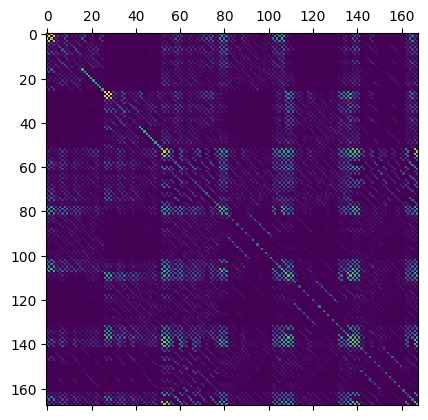

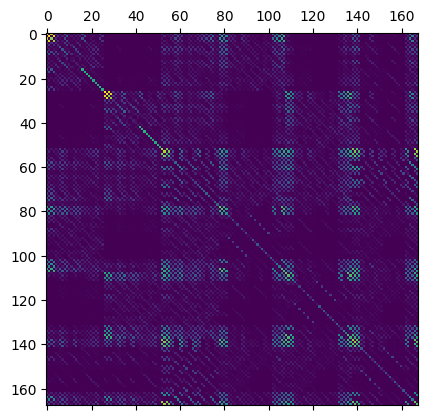

In [108]:
HK, SK = hsk(hamiltonians[2]["H"], ss, dh.sc_off, np.array([0.3, 0, 0]))

myhk = dh.Hk(k=np.array([0.3, 0, 0]))

abs(HK - myhk.toarray()).max()

plt.matshow(abs(HK))
plt.matshow(abs(myhk.toarray()))

In [109]:
if rank == root_node:
    print("Starting matrix inversions")
    print(f"Total number of k points: {kset.shape[0]}")
    print(f"Number of energy samples per k point: {eset}")
    print(f"Total number of directions: {len(hamiltonians)}")
    print(
        f"Total number of matrix inversions: {kset.shape[0] * len(hamiltonians) * eset}"
    )
    print(f"The shape of the Hamiltonian and the Greens function is {NO}x{NO}={NO*NO}")
    # https://stackoverflow.com/questions/70746660/how-to-predict-memory-requirement-for-np-linalg-inv
    # memory is O(64 n**2) for complex matrices
    memory_size = getsizeof(hamiltonians[0]["H"].base) / 1024
    print(
        f"Memory taken by a single Hamiltonian is: {getsizeof(hamiltonians[0]['H'].base) / 1024} KB"
    )
    print(f"Expected memory usage per matrix inversion: {memory_size * 32} KB")
    print(
        f"Expected memory usage per k point for parallel inversion: {memory_size * len(hamiltonians) * eset * 32} KB"
    )
    print(
        f"Expected memory usage on root node: {len(np.array_split(kset, size)[0]) * memory_size * len(hamiltonians) * eset * 32 / 1024} MB"
    )
    print(
        "================================================================================================================================================================"
    )

comm.Barrier()
# ----------------------------------------------------------------------

# make energy contour
# we are working in eV now  !
# and sisl shifts E_F to 0 !
cont = make_contour(emin=ebot, enum=eset, p=esetp)
eran = cont.ze

# ----------------------------------------------------------------------
# sampling the integrand on the contour and the BZ
for k in kpcs[rank]:
    wk = wkset[rank]  # weight of k point in BZ integral
    # iterate over reference directions
    for i, hamiltonian_orientation in enumerate(hamiltonians):
        # calculate Greens function
        H = hamiltonian_orientation["H"]
        HK, SK = hsk(H, ss, dh.sc_off, k)
        # HK = HK - Ef * SK
        # Gk = inv(SK * eran.reshape(eset, 1, 1) - HK)

        # solve Greens function sequentially for the energies, because of memory bound
        Gk = np.zeros(shape=(eset, HK.shape[0], HK.shape[1]), dtype="complex128")
        for j in range(eset):
            Gk[j] = inv(SK * eran[j] - HK)

        # store the Greens function slice of the magnetic entities (for now) based on the on-site projections
        for mag_ent in magnetic_entities:
            mag_ent["Gii_tmp"][i] += (
                Gk[:, mag_ent["spin_box_indeces"], :][:, :, mag_ent["spin_box_indeces"]]
                * wk
            )

        for pair in pairs:
            # add phase shift based on the cell difference
            phase = np.exp(1j * 2 * np.pi * k @ pair["Ruc"].T)

            # get the pair orbital sizes from the magnetic entities
            ai = magnetic_entities[pair["ai"]]["spin_box_indeces"]
            aj = magnetic_entities[pair["aj"]]["spin_box_indeces"]

            # store the Greens function slice of the magnetic entities (for now) based on the on-site projections
            pair["Gij_tmp"][i] += Gk[:, ai][..., aj] * phase * wk
            pair["Gji_tmp"][i] += Gk[:, aj][..., ai] / phase * wk

# summ reduce partial results of mpi nodes
for i in range(len(hamiltonians)):
    for mag_ent in magnetic_entities:
        comm.Reduce(mag_ent["Gii_tmp"][i], mag_ent["Gii"][i], root=root_node)

    for pair in pairs:
        comm.Reduce(pair["Gij_tmp"][i], pair["Gij"][i], root=root_node)
        comm.Reduce(pair["Gji_tmp"][i], pair["Gji"][i], root=root_node)

if rank == root_node:
    times["green_function_inversion_time"] = timer()
    print(
        f"Calculated Greens functions. Elapsed time: {times['green_function_inversion_time']} s"
    )
    print(
        "================================================================================================================================================================"
    )

Starting matrix inversions
Total number of k points: 100
Number of energy samples per k point: 600
Total number of directions: 3
Total number of matrix inversions: 180000
The shape of the Hamiltonian and the Greens function is 84x84=7056
Memory taken by a single Hamiltonian is: 0.015625 KB
Expected memory usage per matrix inversion: 0.5 KB
Expected memory usage per k point for parallel inversion: 900.0 KB
Expected memory usage on root node: 87.890625 MB


k loop: 100%|██████████| 100/100 [1:39:50<00:00, 59.90s/it]  

Calculated Greens functions. Elapsed time: 3878.870911625 s


In [110]:
if rank == root_node:
    # iterate over the magnetic entities
    for tracker, mag_ent in enumerate(magnetic_entities):
        # iterate over the quantization axes
        for i, Gii in enumerate(mag_ent["Gii"]):
            storage = []
            # iterate over the first and second order local perturbations
            for Vu1, Vu2 in zip(mag_ent["Vu1"][i], mag_ent["Vu2"][i]):
                # The Szunyogh-Lichtenstein formula
                traced = np.trace((Vu2 @ Gii + 0.5 * Gii @ Vu1 @ Gii), axis1=1, axis2=2)
                # evaluation of the contour integral
                storage.append(np.trapz(-1 / np.pi * np.imag(traced * cont.we)))

            # fill up the magnetic entities dictionary with the energies
            magnetic_entities[tracker]["energies"].append(storage)
        # convert to np array
        magnetic_entities[tracker]["energies"] = np.array(
            magnetic_entities[tracker]["energies"]
        )
    print("Magnetic entities integrated.")

    # iterate over the pairs
    for tracker, pair in enumerate(pairs):
        # iterate over the quantization axes
        for i, (Gij, Gji) in enumerate(zip(pair["Gij"], pair["Gji"])):
            site_i = magnetic_entities[pair["ai"]]
            site_j = magnetic_entities[pair["aj"]]

            storage = []
            # iterate over the first order local perturbations in all possible orientations for the two sites
            for Vui in site_i["Vu1"][i]:
                for Vuj in site_j["Vu1"][i]:
                    # The Szunyogh-Lichtenstein formula
                    traced = np.trace((Vui @ Gij @ Vuj @ Gji), axis1=1, axis2=2)
                    # evaluation of the contour integral
                    storage.append(np.trapz(-1 / np.pi * np.imag(traced * cont.we)))
            # fill up the pairs dictionary with the energies
            pairs[tracker]["energies"].append(storage)
        # convert to np array
        pairs[tracker]["energies"] = np.array(pairs[tracker]["energies"])

    print("Pairs integrated.")

    # calculate magnetic parameters
    for pair in pairs:
        J_iso, J_S, D, J = calculate_exchange_tensor(pair)
        pair["J_iso"] = J_iso * sisl.unit_convert("eV", "meV")
        pair["J_S"] = J_S * sisl.unit_convert("eV", "meV")
        pair["D"] = D * sisl.unit_convert("eV", "meV")
        pair["J"] = J * sisl.unit_convert("eV", "meV")

    print("Magnetic parameters calculated.")

    times["end_time"] = timer()
    print(
        "##################################################################### GROGU OUTPUT #############################################################################"
    )

    print_parameters(simulation_parameters)
    print_atoms_and_pairs(magnetic_entities, pairs)
    print_runtime_information(times)

    # remove clutter from magnetic entities and pair information
    for pair in pairs:
        del pair["Gij"]
        del pair["Gij_tmp"]
        del pair["Gji"]
        del pair["Gji_tmp"]
    for mag_ent in magnetic_entities:
        del mag_ent["Gii"]
        del mag_ent["Gii_tmp"]
        del mag_ent["Vu1"]
        del mag_ent["Vu2"]
    # create output dictionary with all the relevant data
    results = dict(
        parameters=simulation_parameters,
        magnetic_entities=magnetic_entities,
        pairs=pairs,
        runtime=times,
    )
    # save dictionary
    with open(outfile, "wb") as output_file:
        pickle.dump(results, output_file)

Magnetic entities integrated.
Pairs integrated.
Magnetic parameters calculated.
##################################################################### GROGU OUTPUT #############################################################################
Input file: 
/Users/danielpozsar/Downloads/nojij/Fe3GeTe2/monolayer/soc/lat3_791/Fe3GeTe2.fdf
Output file: 
./Fe3GeTe2.pickle
Number of nodes in the parallel cluster:  1
Cell [Ang]: 
[[ 3.79100000e+00  0.00000000e+00  0.00000000e+00]
 [-1.89550000e+00  3.28310231e+00  0.00000000e+00]
 [ 1.25954923e-15  2.18160327e-15  2.05700000e+01]]
DFT axis: 
[0 0 1]
Quantization axis and perpendicular rotation directions:
[1 0 0]  --»  [array([0, 1, 0]), array([0, 0, 1])]
[0 1 0]  --»  [array([1, 0, 0]), array([0, 0, 1])]
[0 0 1]  --»  [array([1, 0, 0]), array([0, 1, 0])]
Parameters for the contour integral:
Number of k points:  10
k point directions:  xy
Ebot:  -13
Eset:  600
Esetp:  10000
Atomic information: 
---------------------------------------------------

In [111]:
========================================
 
Atom Angstrom
# Label,        x           y           z          Sx           Sy           Sz         #Q           Lx           Ly           Lz           Jx           Jy           Jz
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Te1         1.8955      1.0943      13.1698     -0.0000     0.0000      -0.1543    # 5.9345       -0.0000      0.0000       -0.0537      -0.0000      0.0000       -0.2080   
Te2         1.8955      1.0943      7.4002      0.0000      -0.0000     -0.1543    # 5.9345       0.0000       -0.0000      -0.0537      0.0000       -0.0000      -0.2080   
Ge3         -0.0000     2.1887      10.2850     0.0000      0.0000      -0.1605    # 3.1927       -0.0000      0.0000       0.0012       0.0000       0.0000       -0.1593   
Fe4         -0.0000     0.0000      11.6576     0.0001      -0.0001     2.0466     # 8.3044       0.0000       -0.0000      0.1606       0.0001       -0.0001      2.2072    
Fe5         -0.0000     0.0000      8.9124      -0.0001     0.0001      2.0466     # 8.3044       -0.0000      0.0000       0.1606       -0.0001      0.0001       2.2072    
Fe6         1.8955      1.0944      10.2850     0.0000      0.0000      1.5824     # 8.3296       -0.0000      -0.0000      0.0520       -0.0000      0.0000       1.6344    
==================================================================================================================================
 
Exchange meV
--------------------------------------------------------------------------------
# at1     at2   i  j  k    #    d (Ang)
--------------------------------------------------------------------------------
Fe4     Fe5     0  0  0    #    2.7452
Isotropic -82.0854
DMI 0.12557 -0.00082199  6.9668e-08
Symmetric-anisotropy -0.60237    -0.83842 -0.00032278 -1.2166e-05 -3.3923e-05
--------------------------------------------------------------------------------
Fe4     Fe6     0  0  0    #    2.5835
Isotropic -41.9627
DMI 1.1205     -1.9532   0.0018386
Symmetric-anisotropy 0.26007 -0.00013243     0.12977   -0.069979   -0.042066
--------------------------------------------------------------------------------


SyntaxError: invalid syntax (3105939143.py, line 1)